In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [3]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy import stats, signal
from loading import load_session_data
from target import build_tgt_matrix, get_spike_counts, build_silence_and_noise_events,\
        get_idxs_of_event_periods, build_silence_matrix, get_spike_times_at
from hallucinations import get_pop_resp_profile_mx

np.set_printoptions(suppress=True)

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [162]:
sessions = [s for s in selected_008229.keys()]
sessions.sort()
sessions

['008229_hippoSIT_2022-05-16_20-36-44',
 '008229_hippoSIT_2022-05-17_21-44-43',
 '008229_hippoSIT_2022-05-18_14-36-18',
 '008229_hippoSIT_2022-05-20_15-54-39']

In [163]:
selected = sessions[:]
selected

['008229_hippoSIT_2022-05-16_20-36-44',
 '008229_hippoSIT_2022-05-17_21-44-43',
 '008229_hippoSIT_2022-05-18_14-36-18',
 '008229_hippoSIT_2022-05-20_15-54-39']

In [164]:
for session in selected:
    session_data = load_session_data(session, load_aeps=False)

    animal = session.split('_')[0]
    tl = session_data['tl']
    single_units = session_data['single_units']
    spike_times = session_data['spike_times']
    unit_names = session_data['unit_names']
    h5_file = session_data['h5_file']
    metronome_file = os.path.join(source, animal, session, 'metronome.h5')

    # build response profile matrix
    hw, bc = 0.25, 31
    profile_mx, bins_prof = get_pop_resp_profile_mx(source, session, unit_names, hw, bc)
    profile_mx_half = profile_mx[:, 15:]
    
    # read unit activity matrices
    iter_count = 1000
    idx_sl_max = 600  # maximum time to get prediction slice
    with h5py.File(metronome_file, 'r') as f:
        unit_amx_all = np.array(f['unit_amx_silence_after_noise'])
        
    bin_count = 30
    phase_det  = np.zeros([iter_count, 3]) # true, original and shuffled detections
    slices_orig = np.zeros([iter_count, bin_count])
    slices_shuf = np.zeros([iter_count, bin_count])
    slices = [slices_orig, slices_shuf]

    for i in range(iter_count):
        # getting random original / shuffled activity matrices
        idx = np.random.randint(unit_amx_all.shape[0])
        uam_orig = unit_amx_all[idx]
        uam_shuf = np.random.default_rng().permuted(uam_orig, axis=1)
        #uam_shuf = np.random.default_rng().permuted(uam_shuf, axis=0)

        # select a random 0.25s slice
        idx_sl_start = np.random.randint(idx_sl_max - bin_count)
        sl_l_idx, sl_r_idx = idx_sl_start, idx_sl_start + bin_count
        u_slice_orig = uam_orig[:, sl_l_idx:sl_r_idx]
        u_slice_shuf = uam_shuf[:, sl_l_idx:sl_r_idx]

        # CCR matrix for slices
        dph = []
        for j, sl in enumerate([u_slice_orig, u_slice_shuf]):
            slice_CCR_mx = np.zeros(sl.shape)
            for unit_idx in range(len(profile_mx_half)):
                prof = profile_mx_half[unit_idx]
                spks = sl[unit_idx]
                slice_CCR_mx[unit_idx] = signal.correlate(spks, prof, mode='same')
            slices[j][i] = slice_CCR_mx.mean(axis=0)
            dph.append(slice_CCR_mx.mean(axis=0)[7:22].argmax())

        # collect detections
        phase_det[i] = np.array([15 - idx_sl_start % 15, dph[0], dph[1]])
        
    with h5py.File(metronome_file, 'a') as f:
        if 'phase_detection_after_noise' in f:
            del f['phase_detection_after_noise']
        f.create_dataset('phase_detection_after_noise', data=phase_det)
    print('Session %s done' % session[-19:-9])

Session 2022-05-16 done
Session 2022-05-17 done
Session 2022-05-18 done
Session 2022-05-20 done


## Single session prediction / shuffle

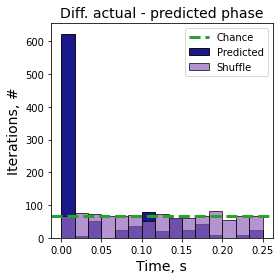

In [137]:
session = sessions[1]

with h5py.File(metronome_file, 'r') as f:
    phase_det = np.array(f['phase_detection_after_noise'])
    
delta_phase_orig = (phase_det[:, 0] - phase_det[:, 1])
delta_phase_orig = delta_phase_orig % 15
delta_phase_shuf = (phase_det[:, 0] - phase_det[:, 2])
delta_phase_shuf = delta_phase_shuf % 15

vals_orig, bins = np.histogram(delta_phase_orig, bins=np.linspace(0, 15, 16))
vals_shuf, bins = np.histogram(delta_phase_shuf, bins=np.linspace(0, 15, 16))

fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.hist(bins[:-1], bins=bins, weights=vals_orig, edgecolor='black', color='navy', alpha=0.9, label='Predicted')
ax.hist(bins[:-1], bins=bins, weights=vals_shuf, edgecolor='black', color='tab:purple', alpha=0.7, label='Shuffle')
ax.set_title('Diff. actual - predicted phase', fontsize=14)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Iterations, #', fontsize=14)
ax.axhline(1000/15, ls='--', lw=3, color='tab:green', label='Chance')
ax.legend(loc='upper right')
_ = ax.set_xticks(np.arange(0, 16, 3))
_ = ax.set_xticklabels(["%.2f" % x for x in np.arange(0, 0.3, 3*0.05/3)], fontsize=10)
fig.tight_layout()
#fig.savefig(os.path.join(report, 'Hall', 'diff_act_pred_phase.png'), dpi=500)

(0.0, 14.0)

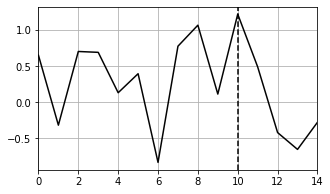

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

idx = 12
#ax.axvline(phase_det[idx][0])
ax.axvline(slices_shuf[idx][7:22].argmax(), ls='--', color='black')
ax.plot(slices_shuf[idx][7:22], color='black', alpha=0.99)
ax.grid()
ax.set_xlim(0, 14)

In [98]:
# test file contents
for session in sessions:
    animal = session.split('_')[0]
    metronome_file = os.path.join(source, animal, session, 'metronome.h5')
    
    if not os.path.exists(metronome_file):
        print("%s: no file" % session)
    else:
        with h5py.File(metronome_file, 'r') as f:
            print("%s: %s" % (session, 'unit_amx_silence_all' in f))

009265_hippoSIT_2023-02-24_09-53-26: no file
009265_hippoSIT_2023-02-24_17-22-46: no file
009265_hippoSIT_2023-02-27_10-18-32: no file
009265_hippoSIT_2023-02-27_15-33-46: no file
009265_hippoSIT_2023-02-28_09-16-50: no file
009265_hippoSIT_2023-02-28_13-16-10: no file
009265_hippoSIT_2023-02-28_20-45-04: no file
009265_hippoSIT_2023-03-01_10-46-12: no file
009265_hippoSIT_2023-03-02_09-32-54: no file
009265_hippoSIT_2023-03-02_16-27-42: False
009265_hippoSIT_2023-03-02_20-11-35: no file
009265_hippoSIT_2023-03-03_09-37-07: no file
009265_hippoSIT_2023-03-03_16-00-47: no file
009265_hippoSIT_2023-03-04_11-12-04: no file
009265_hippoSIT_2023-03-05_11-52-17: no file
009265_hippoSIT_2023-03-05_18-31-32: no file
009265_hippoSIT_2023-03-08_18-10-07: no file
009265_hippoSIT_2023-03-09_20-03-08: no file
009265_hippoSIT_2023-03-10_09-57-34: no file
009265_hippoSIT_2023-04-13_09-54-39: no file
009265_hippoSIT_2023-04-20_11-39-02: no file


## Population stats

In [5]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
selected = sessions
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [13]:
pred_stats = np.zeros([len(selected), 2])
for i, session in enumerate(selected):
    animal = session.split('_')[0]
    metronome_file = os.path.join(source, animal, session, 'metronome.h5')
    
    with h5py.File(metronome_file, 'r') as f:
        #phase_det = np.array(f['phase_detection_after_noise'])
        phase_det = np.array(f['phase_detection'])#_after_noise'])

    delta_phase_orig = (phase_det[:, 0] - phase_det[:, 1])
    delta_phase_orig = delta_phase_orig % 15
    delta_phase_shuf = (phase_det[:, 0] - phase_det[:, 2])
    delta_phase_shuf = delta_phase_shuf % 15

    vals_orig, bins = np.histogram(delta_phase_orig, bins=np.linspace(0, 15, 16))
    vals_shuf, bins = np.histogram(delta_phase_shuf, bins=np.linspace(0, 15, 16))

    pred_stats[i] = vals_orig[0]/1000, vals_shuf[0]/1000

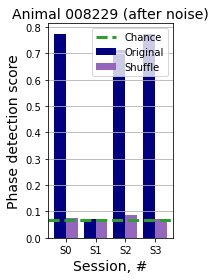

In [168]:
labels = ['S%d' % d for d in range(len(selected))]
predicted = pred_stats[:, 0]
shuffle   = pred_stats[:, 1]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(0.65*len(selected), 4))
rects1 = ax.bar(x - width/2, predicted, width, label='Original', color='navy')
rects2 = ax.bar(x + width/2, shuffle, width, label='Shuffle', color='tab:purple')
ax.axhline(1/15, ls='--', lw=3, color='tab:green', label='Chance')
ax.set_xlabel('Session, #', fontsize=14)
ax.set_ylabel('Phase detection score', fontsize=14)
ax.set_title('Animal %s (after noise)' % animal, fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y')
fig.tight_layout()
fig.savefig(os.path.join(report, 'Hall', 'phase_det_scores_%s_after_noise.png' % animal), dpi=500)

In [14]:
# get unit counts for all selected sessions
unit_counts = np.zeros(len(selected))
for i, session in enumerate(selected):
    animal = session.split('_')[0]
    h5_file = os.path.join(source, animal, session, session + '.h5')
    with h5py.File(h5_file, 'r') as f:
        unit_counts[i] = len(f['units'])

In [8]:
# noise periods count
noise_counts = []
for session in selected:
    animal      = session.split('_')[0]
    h5_file     = os.path.join(source, animal, session, session + '.h5')
    with h5py.File(h5_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    
    periods = get_idxs_of_event_periods(tl, 0)  # silences
    noise_p_idxs = np.array([i for i, p in enumerate(periods) if tl[p[0] - 1][6] < 0])
    noise_counts.append(len(noise_p_idxs))
noise_counts = np.array(noise_counts)

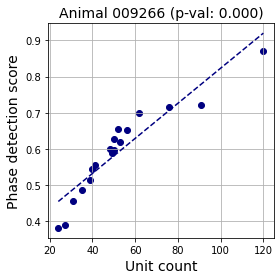

In [16]:
st = unit_counts
#st = noise_counts

regress = stats.linregress(st, pred_stats[:, 0])
x = np.array([st.min(), st.max()])
y = regress[0] * x + regress[1]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(st, pred_stats[:, 0], color='navy')
ax.plot(x, y, color='navy', ls='--')
ax.grid()
ax.set_xlabel('Unit count', fontsize=14)
#ax.set_xlabel('Noise periods count', fontsize=14)
ax.set_ylabel('Phase detection score', fontsize=14)
ax.set_title('Animal %s (p-val: %.3f)' % (animal, regress[3]), fontsize=14)
fig.tight_layout()
fig.savefig(os.path.join(report, 'Hall', 'unit_count_phase_det_score_%s.png' % animal), dpi=500)